# Análisis COVID-19 en Colombia

Dada la coyuntura mundial que estamos viviendo, he decidido hacer un análisis sencillo de los casos de COVID-19 en Colombia.

La fuente de datos que uso es una URL JSON que tiene publicada el Instituto Nacional de Salud.  Esta fuente tiene el reporte detallado de cada caso y es actualizada al menos 2 veces al día.

La URL de la fuente de datos es: https://e.infogram.com/api/live/flex/bc384047-e71c-47d9-b606-1eb6a29962e3/664bc407-2569-4ab8-b7fb-9deb668ddb7a

Esta fuente de datos tiene varias particularidades:

- En ocasiones la estructura de datos no es la esperada.  Al parecer tienen problemas cuando la actualizan.
- El manejo de fecha de reporte, no tiene una estructura estándar. En ocasiones se devuelve como MM/DD/YYYY, pero en otras se devuelve como DD/MM/YYYY
- La columna Atención, Ciudades y País de procedencia tiene problemas de normalización, es decir, escriben el mismo dato de diferentes formas o con espacios al inicio o al final.


## Ingesta de datos

Los datos se obtienen directamente de la URL publicada por INS. Este es un archivo JSON.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from IPython.core.display import display, HTML

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
uri = 'https://e.infogram.com/api/live/flex/bc384047-e71c-47d9-b606-1eb6a29962e3/664bc407-2569-4ab8-b7fb-9deb668ddb7a'
resp = requests.get(uri)
txt = resp.json()
data = pd.DataFrame(txt['data'][0])
new_header = data.iloc[0] 
data = data[1:] 
data.columns = new_header
data.rename(columns={"Tipo*": "Tipo"}, inplace = True)

## Preparación de datos

Como lo mencionaba anteriormente, los datos llegan con problemas de formato y se debe arreglar para el correcto análisis

In [3]:
# Ajuste de formato de fechas
data['Fecha de diagnóstico'] = pd.to_datetime(data['Fecha de diagnóstico'], dayfirst=True) #, dayfirst=True
# Ajuste de columna Atención por uso de mayusculas mezcladas
data['Atención'] = data['Atención'].str.lower()
# Ajuste de columna Edad por elementos duplicados por dobles espacios
data['Edad'] = data['Edad'].replace('\s+', ' ', regex=True)
# Ajuste de columna Edad por elementos duplicados por dobles espacios y paises múltiples separados por guiones
data['País de procedencia'] = data['País de procedencia'].str.split('-').str[0].replace('\s+', ' ', regex=True)
data['País de procedencia'] = data['País de procedencia'].str.strip()

Revisamos que la tabla ya este correctamente formada:

In [4]:
data.tail(5)

,ID de caso,Fecha de diagnóstico,Ciudad de ubicación,Departamento,Atención,Edad,Sexo,Tipo,País de procedencia
302,302,2020-03-23,Villavicencio,Meta,casa,30 a 39,F,Importado,Estados Unidos
303,303,2020-03-23,Itagüí,Antioquia,casa,70 a 79,F,Importado,Estados Unidos
304,304,2020-03-23,Bello,Antioquia,casa,30 a 39,M,Importado,Estados Unidos
305,305,2020-03-23,Villavicencio,Meta,casa,20 a 29,M,Importado,Ecuador
306,306,2020-03-23,Rionegro,Antioquia,casa,20 a 29,M,Importado,Brasil


## Exploración Inicial

A continuación, voy a mostrar algunas estadísticas básicas de los datos analizados:

In [5]:
data_describe = data.describe().loc['unique']
conteo_casos_totales = data_describe['ID de caso']
conteo_casos_departamentos = data_describe['Departamento']
conteo_casos_ciudades = data_describe['Ciudad de ubicación']

In [6]:
display(HTML('<h3>Número de casos: '+ str(conteo_casos_totales) +'</h3>'))
display(HTML('<h4>Departamentos afectados: '+ str(conteo_casos_departamentos) +'</h4>'))
display(HTML('<h4>Ciudades afectadas: '+ str(conteo_casos_ciudades) +'</h4>'))

## Análisis de datos

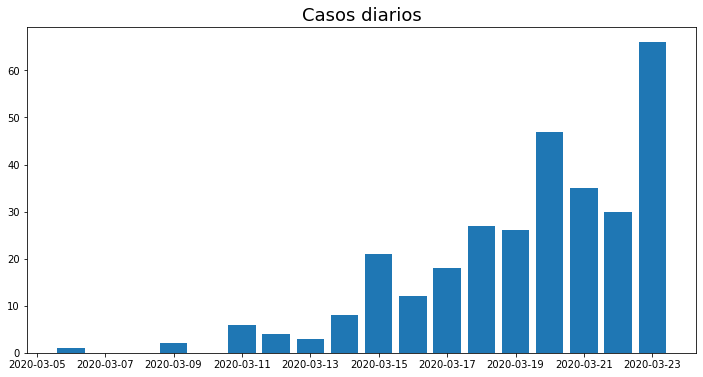

In [7]:
casos_x_fecha = data.groupby(['Fecha de diagnóstico']).size().fillna(0)
plt.figure(figsize = (12,6))
plt.bar( casos_x_fecha.index, casos_x_fecha)
plt.title('Casos diarios', fontsize=18);

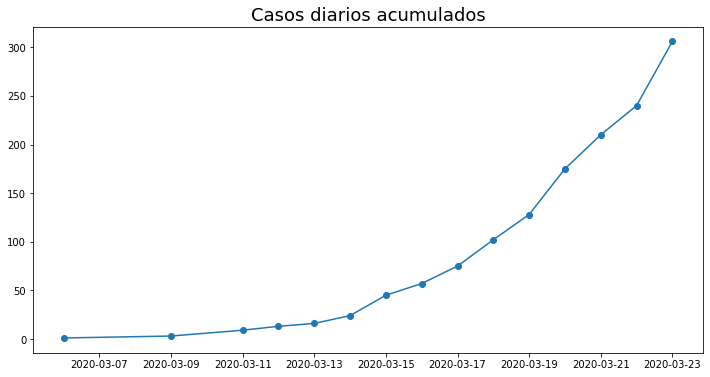

In [8]:
casos_x_fecha_acum = casos_x_fecha.cumsum()
plt.figure(figsize = (12,6))
plt.plot( casos_x_fecha_acum, linestyle='-', marker='o')
plt.title('Casos diarios acumulados', fontsize=18);

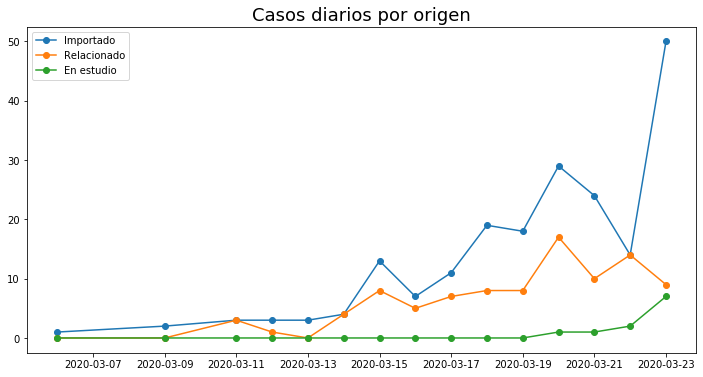

In [9]:
casos_x_fecha_tipo = data.groupby(['Fecha de diagnóstico','Tipo']).size().unstack('Tipo').fillna(0)
casos_x_fecha_tipo = casos_x_fecha_tipo.reindex(casos_x_fecha_tipo.sum().sort_values(ascending=False).index, axis=1)

plt.figure(figsize = (12,6))
plt.plot(casos_x_fecha_tipo, linestyle='-', marker='o')
plt.legend(casos_x_fecha_tipo.columns.tolist())
plt.title('Casos diarios por origen', fontsize=18);

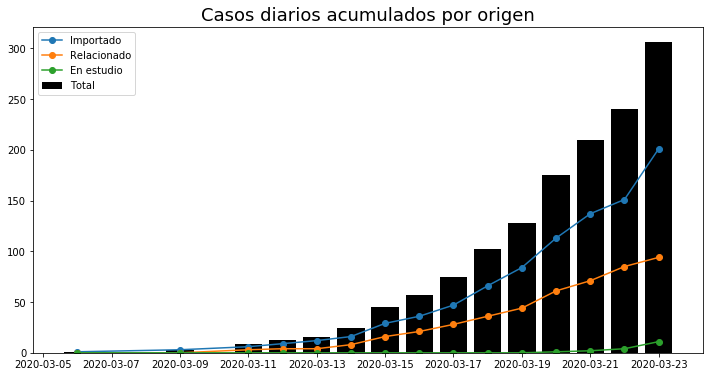

In [10]:
casos_x_fecha_tipo_acum = casos_x_fecha_tipo.cumsum()
plt.figure(figsize = (12,6))
plt.bar( casos_x_fecha_acum.index, casos_x_fecha_acum, color = 'black')
plt.plot( casos_x_fecha_tipo_acum, linestyle='-', marker='o')
plt.legend(casos_x_fecha_tipo_acum.columns.tolist() + ['Total'])
plt.title('Casos diarios acumulados por origen', fontsize=18);

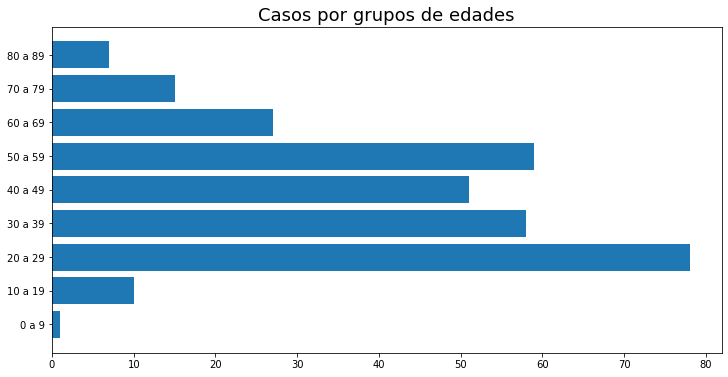

In [11]:
casos_x_edad = data.groupby('Edad').size()
plt.figure(figsize = (12,6))
plt.barh(casos_x_edad.index, casos_x_edad)
plt.title('Casos por grupos de edades', fontsize=18);

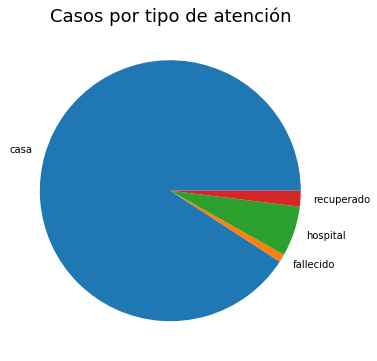

In [12]:
casos_x_atencion = data.groupby('Atención').size()
plt.figure(figsize = (12,6))
plt.pie(casos_x_atencion, labels = casos_x_atencion.index)
plt.title('Casos por tipo de atención', fontsize=18);

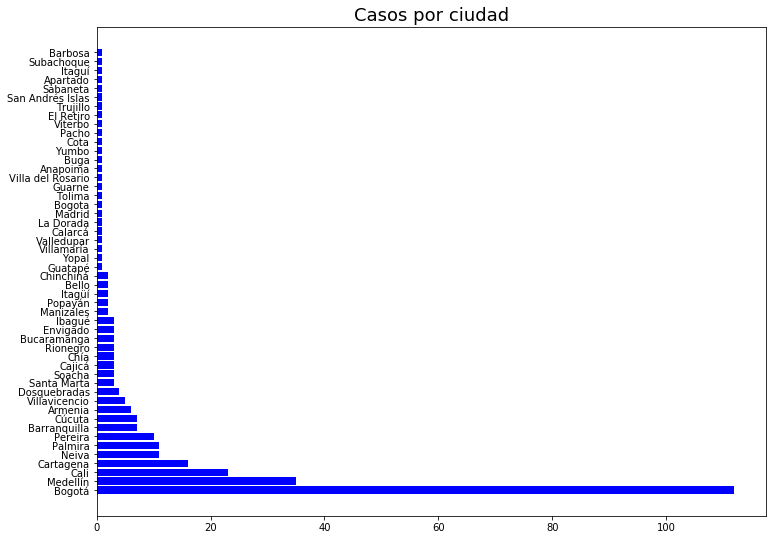

In [13]:
casos_x_ubicacion = data['Ciudad de ubicación'].value_counts()
plt.figure(figsize = (12,9))
plt.barh( casos_x_ubicacion.index, casos_x_ubicacion, color = 'blue')
plt.title('Casos por ciudad', fontsize=18);

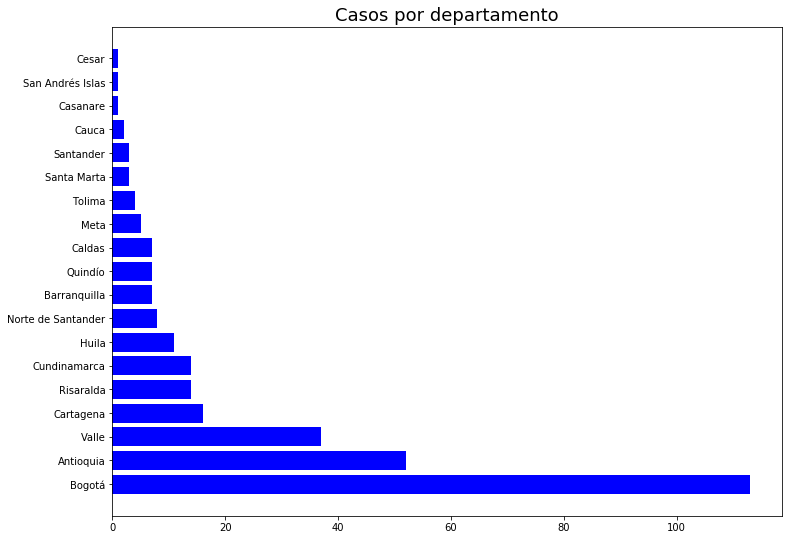

In [14]:
casos_x_departamento = data['Departamento'].value_counts()
plt.figure(figsize = (12,9))
plt.barh( casos_x_departamento.index, casos_x_departamento, color = 'blue')
plt.title('Casos por departamento', fontsize=18);

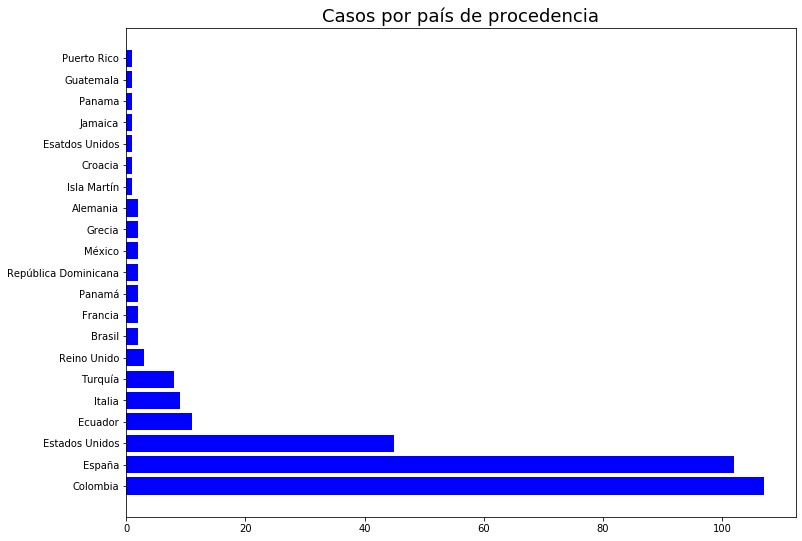

In [15]:
casos_x_pais = data['País de procedencia'].value_counts()
plt.figure(figsize = (12,9))
plt.barh( casos_x_pais.index, casos_x_pais, color = 'blue')
plt.title('Casos por país de procedencia', fontsize=18);

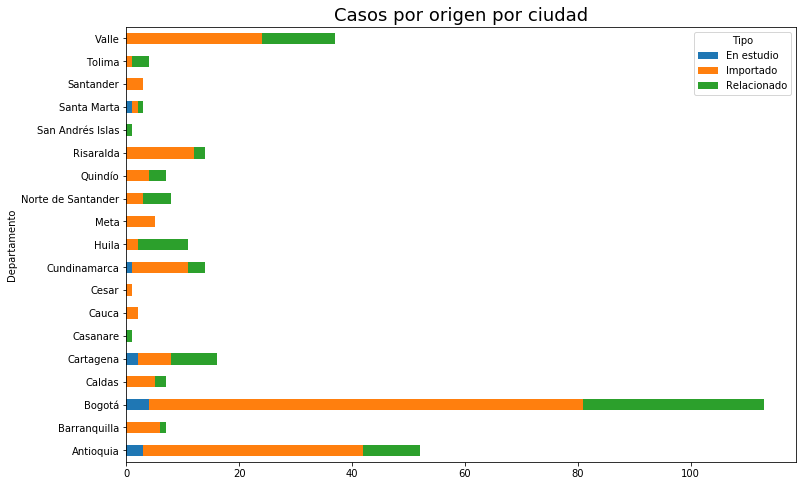

In [16]:
casos_x_departamento_tipo = data.groupby(['Departamento','Tipo']).size().unstack('Tipo').fillna(0)
casos_x_departamento_tipo.plot(kind = 'barh', stacked=True, figsize = (12,8))
plt.title('Casos por origen por ciudad', fontsize=18);

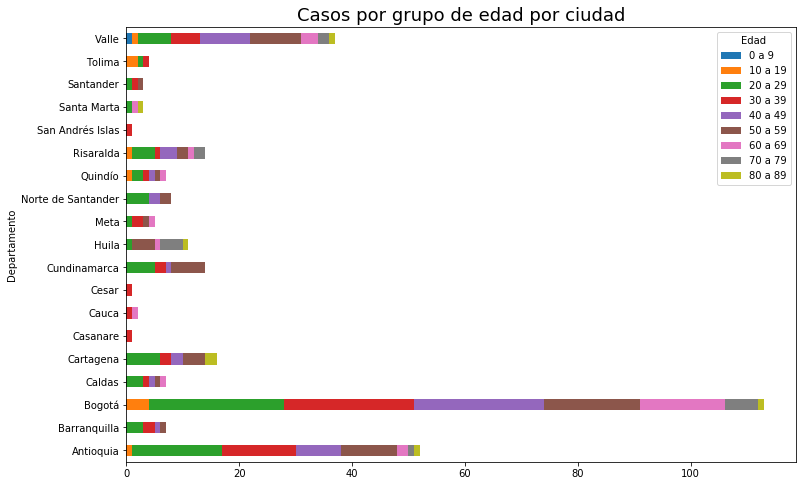

In [17]:
casos_x_departamento_edad = data.groupby(['Departamento','Edad']).size().unstack('Edad').fillna(0)
casos_x_departamento_edad.plot(kind = 'barh', stacked=True, figsize = (12,8))
plt.title('Casos por grupo de edad por ciudad', fontsize=18);

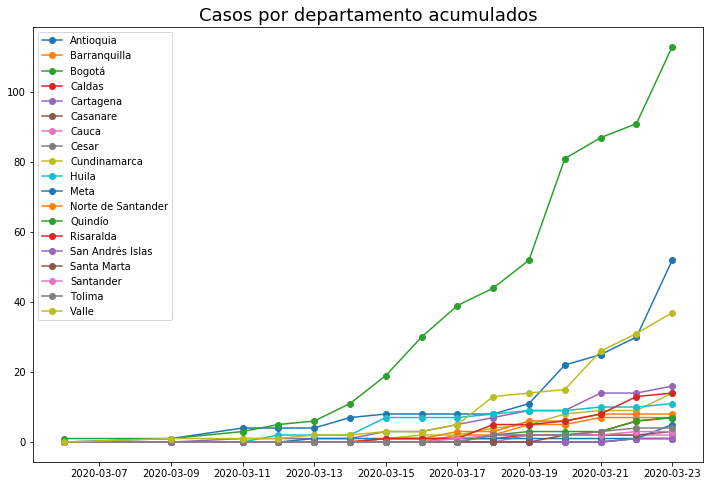

In [18]:
casos_x_fecha_departamento_acum = data.groupby(['Fecha de diagnóstico','Departamento']).size().unstack('Departamento').fillna(0).cumsum()
plt.figure(figsize = (12,8))
plt.plot(casos_x_fecha_departamento_acum, linestyle='-', marker='o')
plt.legend(casos_x_fecha_departamento_acum.columns)
plt.title('Casos por departamento acumulados', fontsize=18);

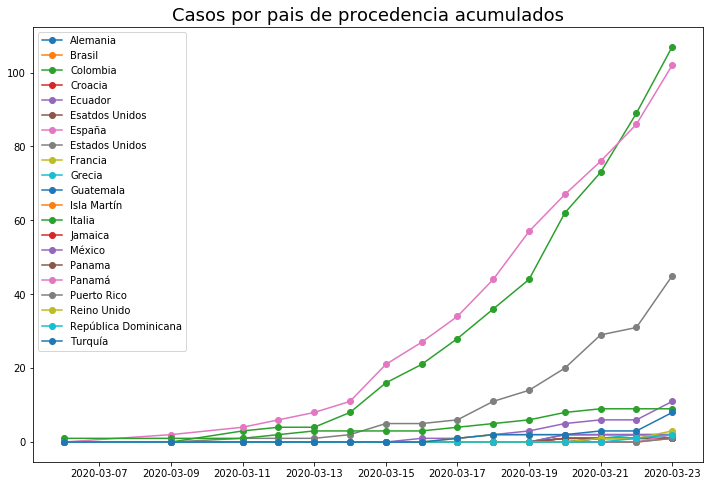

In [19]:
casos_x_fecha_procedencia_acum = data.groupby(['Fecha de diagnóstico','País de procedencia']).size().unstack('País de procedencia').fillna(0).cumsum()
plt.figure(figsize = (12,8))
plt.plot( casos_x_fecha_procedencia_acum, linestyle='-', marker='o')
plt.legend(casos_x_fecha_procedencia_acum.columns)
plt.title('Casos por pais de procedencia acumulados', fontsize=18);

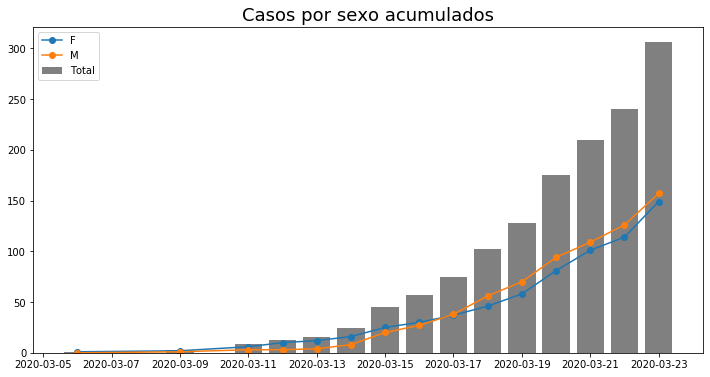

In [20]:
casos_x_fecha_sexo_acum = data.groupby(['Fecha de diagnóstico','Sexo']).size().unstack('Sexo').fillna(0).cumsum()

plt.figure(figsize = (12,6))
plt.bar( casos_x_fecha_acum.index, casos_x_fecha_acum, color = 'gray')
plt.plot( casos_x_fecha_sexo_acum, linestyle='-', marker='o')
plt.legend(casos_x_fecha_sexo_acum.columns.tolist() + ['Total'])
plt.title('Casos por sexo acumulados', fontsize=18);

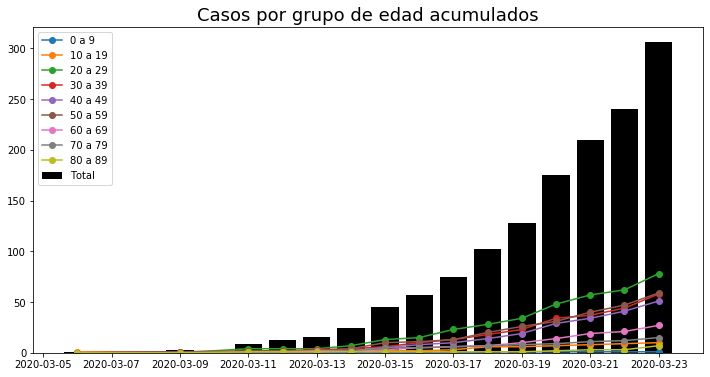

In [21]:
casos_x_fecha_edad_acum = data.groupby(['Fecha de diagnóstico','Edad']).size().unstack('Edad').fillna(0).cumsum()

plt.figure(figsize = (12,6))
plt.bar( casos_x_fecha_acum.index, casos_x_fecha_acum, color = 'black')
plt.plot( casos_x_fecha_edad_acum, linestyle='-', marker='o')
plt.legend(casos_x_fecha_edad_acum.columns.tolist() + ['Total'])
plt.title('Casos por grupo de edad acumulados', fontsize=18);

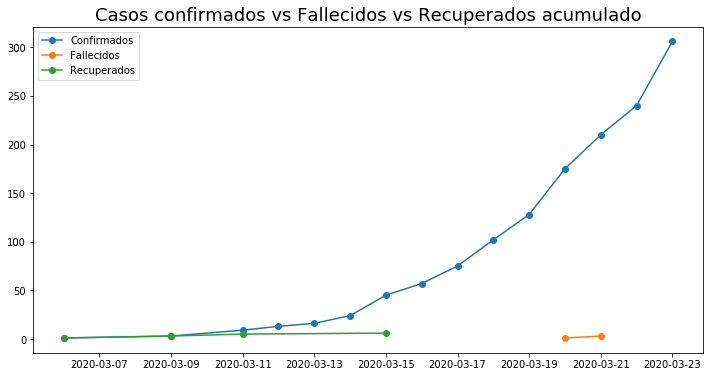

In [22]:
fallecidos_x_fecha = data[data['Atención'] == 'fallecido'].groupby(['Fecha de diagnóstico']).size().fillna(0)
fallecidos_x_fecha_acum = fallecidos_x_fecha.cumsum()

recuperados_x_fecha = data[data['Atención'] == 'recuperado'].groupby(['Fecha de diagnóstico']).size().fillna(0)
recuperados_x_fecha_acum = recuperados_x_fecha.cumsum()


plt.figure(figsize = (12,6))
plt.plot( casos_x_fecha_acum, linestyle='-', marker='o')
plt.plot( fallecidos_x_fecha_acum, linestyle='-', marker='o')
plt.plot( recuperados_x_fecha_acum, linestyle='-', marker='o')
plt.legend(['Confirmados', 'Fallecidos', 'Recuperados'])
plt.title('Casos confirmados vs Fallecidos vs Recuperados acumulado', fontsize=18);

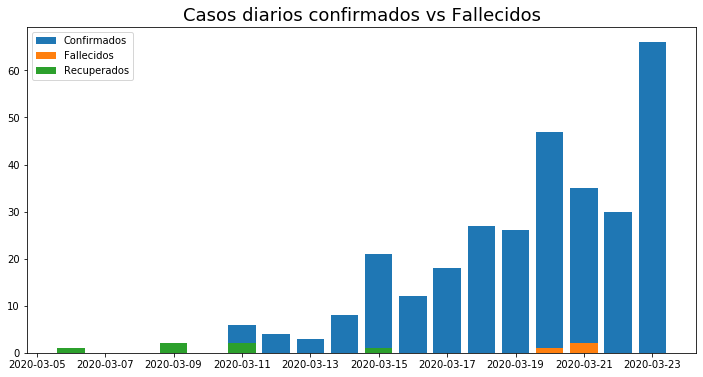

In [23]:
plt.figure(figsize = (12,6))
plt.bar( casos_x_fecha.index, casos_x_fecha);
plt.bar( fallecidos_x_fecha.index, fallecidos_x_fecha);
plt.bar( recuperados_x_fecha.index, recuperados_x_fecha);
plt.legend(['Confirmados', 'Fallecidos', 'Recuperados']);
plt.title('Casos diarios confirmados vs Fallecidos', fontsize=18);

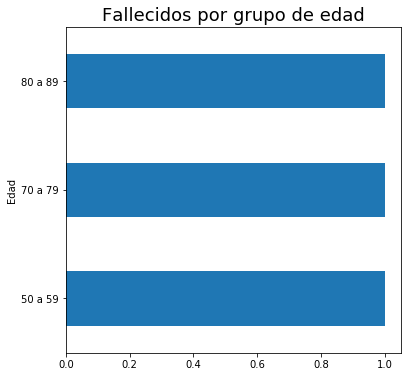

In [24]:
fallecidos_x_edad = data[data['Atención'] == 'fallecido'].groupby(['Edad']).size()
fallecidos_x_edad.plot(kind = 'barh', figsize = (6, 6))
plt.title('Fallecidos por grupo de edad', fontsize=18);

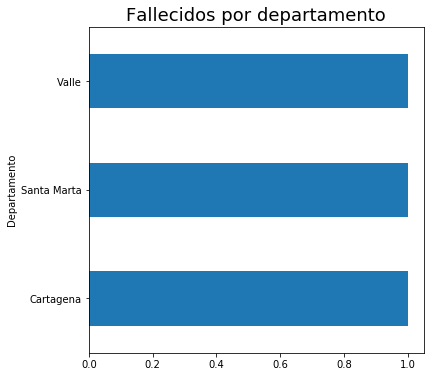

In [25]:
fallecidos_x_departamento = data[data['Atención'] == 'fallecido'].groupby(['Departamento']).size()
fallecidos_x_departamento.plot(kind = 'barh', figsize = (6, 6))
plt.title('Fallecidos por departamento', fontsize=18);